In [1]:

import scipy
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc



In [22]:
def read_gt(gt_file):
    gt = []
    with open(gt_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            items = line.split()
            class_id = int(items[0])
            xc = float(items[1])
            yc = float(items[2])
            w = float(items[3])
            h = float(items[4])
            gt.append([xc, yc, w, h, class_id])
            
    
    return np.array(gt)

def read_yolo_pred(pred_file):
    
    if not pathlib.Path(pred_file).exists():
        raise FileNotFoundError(f'File {pred_file} does not exist')
    with open(pred_file, 'r') as f:
        lines = f.readlines()
        
        
    preds = []
    for line in lines:
        line = line.strip()
        if len(line) == 0:
            continue
        items = line.split()
        xc = float(items[1])
        yc = float(items[2])
        w = float(items[3])
        h = float(items[4])
        class_id = int(float(items[0]))
        conf = float(items[5])
        pred = [xc, yc, w, h, class_id, conf]
        preds.append(pred)
        
    
    return np.array(preds)

In [23]:
def get_cancer_label(filename):
    anots = read_gt(filename)
    if len(anots) == 0:
        return 0
    return int(anots[:, -1].max())


def get_score(filename):
    preds = read_yolo_pred(filename)
    if len(preds) == 0:
        return 0.0
    preds = preds[preds[:, -2] ==1]
    if len(preds) == 0:
        return 0.0
    
    return preds[:, -1].max()
    


    


In [33]:
def get_inbreast_df(dataset_folder, model_name):
    all_gt = list((dataset_folder/'labels').glob('*.txt'))
    all_preds = [pathlib.Path(str(p).replace('labels', model_name)) for p in all_gt]
    print("num of pred files", len(list(all_preds)))
    
    df = pd.DataFrame({'gt': all_gt, 'pred': all_preds})
    df['cancer'] = df['gt'].apply(get_cancer_label)
    df['score'] = df['pred'].apply(get_score)
    df['id'] = df['gt'].apply(lambda x: x.stem.split('_')[1])
    df['laterality'] = df['gt'].apply(lambda x: x.stem.split('_')[-3])
    df['view'] = df['gt'].apply(lambda x: x.stem.split('_')[-2])
    return df
    
def get_ddsm_df(dataset_folder, model_name):
    all_gt = list((dataset_folder/'labels').glob('*.txt'))
    all_preds = [pathlib.Path(str(p).replace('labels', model_name)) for p in all_gt]
    print("num of pred files", len(list(all_preds)))
    df = pd.DataFrame({'gt': all_gt, 'pred': all_preds})
    df['cancer'] = df['gt'].apply(get_cancer_label)
    df['score'] = df['pred'].apply(get_score)
    df['id'] = df['gt'].apply(lambda x: x.stem.split('.')[0])
    df['laterality'] = df['gt'].apply(lambda x: x.stem.split('.')[1].split('_')[0][0])
    df['view'] = df['gt'].apply(lambda x: x.stem.split('.')[1].split('_')[1])
    return df


def calculate_AUC(df):
 
    print("num cases", len(df))
    #plot ROC curve
    fpr, tpr, thresholds = roc_curve(df['cancer'], df['score'])
    sensibility = tpr
    specificity = 1-fpr
    
    plt.plot(specificity, sensibility)
    plt.xlabel('Specificity')
    plt.ylabel('Sensibility')
    
    #find specificity at 90% sensibility
    sensibility_90 = 0.9
    idx = np.argmin(np.abs(sensibility - sensibility_90))
    spec_90 = specificity[idx]
    print("Specificity at 90% sensibility", spec_90)

    #compute AUC for cancer
    return roc_auc_score(df['cancer'], df['score'])


num of pred files 410
                 id laterality  cancer  score
0  1f139436acfc5467          L       0    0.0
1  f62fbf38fb208316          L       1    0.0
2  80123a24997098dc          R       0    0.0
3  8c105bb715bf1c3c          L       0    0.0
4  dcafa6ba6374ec07          L       1    0.0
nuber of scores 25
max score 0.8741791844367981
num cases 410
Specificity at 90% sensibility 0.0
AUC per image 0.5827995379607267
Number of cancer images 89


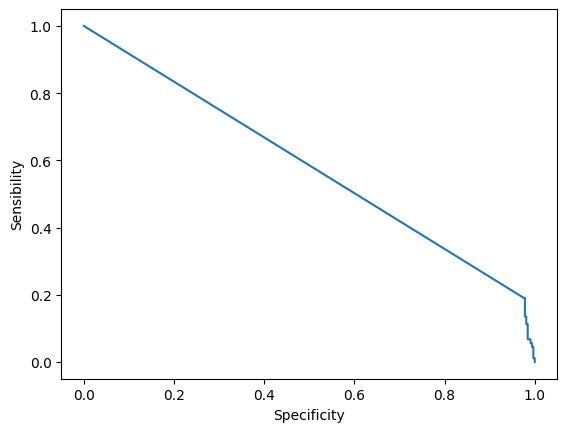

In [34]:
dataset_folder = pathlib.Path('/home/alalbiol/Data/mamo/inbreast_yolo/validation/')
model_name = '23-yolov8n-patch_640'
model_name = '22-continue21-yolov8n-patch_640'

df = get_inbreast_df(dataset_folder, model_name)
print(df[['id', 'laterality','cancer', 'score']].head())
print("nuber of scores", (df.score > 0).sum())

print("max score", df['score'].max())

AUC_per_image = calculate_AUC(df)
print("AUC per image", AUC_per_image)
print("Number of cancer images", df['cancer'].sum())

# df2 = df.groupby(['id', 'laterality']).agg({'cancer': 'max', 'score': 'mean'}).reset_index()
# print(df2.head())
# AUC_per_breast = calculate_AUC(df2)
# print("AUC per breast", AUC_per_breast)


num of pred files 8308
num cases 8308
Specificity at 90% sensibility 0.0
AUC per image 0.5159096995151652
num cases 4154
Specificity at 90% sensibility 0.0
AUC per breast 0.5224878399552849


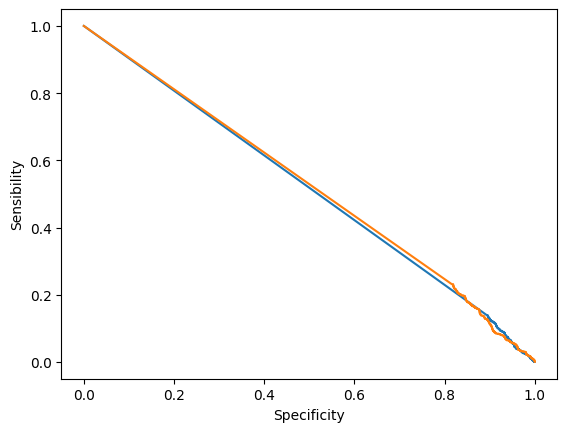

In [36]:
dataset_folder = pathlib.Path('/home/alalbiol/Data/mamo/ddsm_yolo/training/')
model_name = '23-yolov8n-patch_640'
model_name = '22-continue21-yolov8n-patch_640'



df = get_ddsm_df(dataset_folder, model_name)
AUC_per_image = calculate_AUC(df)
print("AUC per image", AUC_per_image)
df2 = df.groupby(['id', 'laterality']).agg({'cancer': 'max', 'score': 'mean'}).reset_index()
AUC_per_breast = calculate_AUC(df2)
print("AUC per breast", AUC_per_breast)

In [19]:
print(df.loc[df.id.str.contains('349323117bf0fd93')])

Empty DataFrame
Columns: [gt, pred, cancer, score, id, laterality, view]
Index: []


# EVALUACION DREAM PILOT

In [20]:
pilot_dataset_folder = pathlib.Path('/home/alalbiol/Data/mamo/dream_pilot_yolo')

In [21]:
images_crosswalk = pd.read_csv(pilot_dataset_folder/'images_crosswalk.tsv', sep='\t')   

In [22]:
def get_model_score(filename, model_name):
    filename = pilot_dataset_folder/model_name/filename.replace('.dcm','.txt')
    return get_score(filename)

images_crosswalk['score'] = images_crosswalk['filename'].apply(get_model_score)

In [23]:
images_crosswalk.head()


,subjectId,examIndex,imageIndex,view,laterality,filename,cancer,score
0,20,1,1,CC,R,000135.dcm,0,0.193386
1,20,1,2,CC,L,000136.dcm,0,0.519703
2,20,1,3,MLO,L,000137.dcm,0,0.014703
3,20,1,4,MLO,R,000138.dcm,0,0.112573
4,98,1,1,CC,R,100151.dcm,0,0.262948


num cases 500
Specificity at 90% sensibility 0.33690987124463523
AUC per image 0.7065135066902297
Number of cancer images 34
num cases 221
Specificity at 90% sensibility 0.24637681159420288
AUC per breast 0.6649413388543823


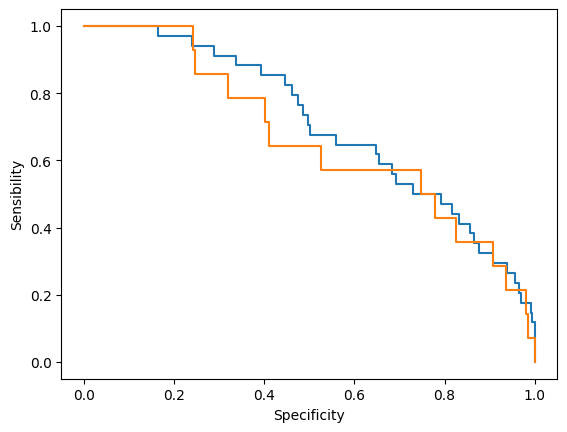

In [24]:
AUC_per_image = calculate_AUC(images_crosswalk)
print("AUC per image", AUC_per_image)
print("Number of cancer images", images_crosswalk['cancer'].sum())

images_crosswalk2 = images_crosswalk.groupby(['subjectId', 'examIndex', 'laterality']).agg({'cancer': 'max', 'score': 'max'}).reset_index()
AUC_per_breast = calculate_AUC(images_crosswalk2)
print("AUC per breast", AUC_per_breast)